In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.datasets import make_regression, make_friedman1, make_blobs
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split

from matplotlib.colors import ListedColormap
from tqdm import tqdm

# Let’s write an auxiliary function that will return grid for further visualization.
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

sns.set()
warnings.filterwarnings("ignore")

## Решающие деревья

Решающие деревья - один из наиболее популярных алгоритмов для решения задач классификации и регрессии. Стоит отметить, что по своей сути они относятся не только к ML, но и к реальной жизни. Например последовательная инструкция является решающим деревом. Рассмотрим фрагмент инструкции для публикаций научных сотрудников ниже.

<img align='center' src='img/hse_instr.png' width=70%><br>

В терминах ML данная инструкция решает элементарную задачу классификации - определить форму публикации по нескольким признакам:

- тип публикации
- где планируется опубликовать
и т.д.

<img align='center' src='img/tree_2.png' width=70%><br>

Решающие деревья - обобщение опыта экспертов. До начала массового использования ML в бизнес-процессах задача банковского скоринга решалась людьми, которые руководствовались правилами, написанными в скоринговых картах. Данные правила можно представить в виде дерева.

В этом случае решается задача _бинарной классификации_ - о выдаче или отказе в получении кредита. Используемые признаки - _возраст, образование, доход, наличие недвижимости_.

### Дерево для задачи классификации:
<img src='img/0_tree.png' Width=900>

# Построение деревьев

* Обучающая выборка $(x_i,y_i)_{i=1}^l\in X \times Y$
* Как разбить на две части: $R_1(j,s)=\{x|x_j \leq s\}$ и $R_2(j,s) = \{x | x_j > s \}$ с использованием критерия Q(X, j, s)?

Найдём наилучшие значения $j$ и $s$, создадим корневую вершину дерева, поставив ей в соответствие функцию (предикат) $[x_j \leq s ]$. Объекты выборки будут разбиты на две части и попадут либо в левое, либо в правое поддерево. Продолжим эту процедуру для каждой подвыборки. Если после очередного разбиения в одной из половин окажутся объекты одного из классов, то создадим листовую вершину, которой будет соответствовать класс попавших в неё объектов.

Жадный алгоритм переусложняет структуру дерева:

<img src='img/0_greedy_tree.png' Width=900>

# Критерии информативности

* $R_m$ - множество объектов обучающей выборки, попавших в вершину $m$.
* $p_{mk}$ - доля объектов класса $k\in\{1, ..., K\}$, попавших в вершину $m$: $p_{mk}=\frac{1}{N_m} \sum\limits_{x_i\in R_m} [y_i = k]$, где  $N_m=|R_m|$.
* $k_m = arg \max\limits_{k} p_{mk}$ - класс, чьих представителей больше всего среди объектов, попавших в вершину $m$.

## 1. Ошибка классификации

Если бы вершина $m$ была листовой и относила все объекты к классу $k$:

$$
H(R_m) = \frac{1}{N_m} \sum\limits_{x_i \in R_m} [y_i \neq k_m].
$$

Критерий информативности при ветвлении вершины $m$: ($l$ и $r$ - правые и левые вершины)

$$
Q(R_m, j, s) = H (R_m) - \frac{N_l}{N_m} H(R_l) - \frac{N_r}{N_m} H(R_r) \to \max\limits_{j, s}
$$

Можно показать путем нескольких преобразований, что критерий представим в виде:
$$H(R_m) = 1 - p_{m, k_m}$$

## 2. Индекс Джини
* Функционал имеет вид $$ H(R_m) = \sum\limits_{k \neq k'}p_{mk}p_{mk'}$$
* Аналогично определяется критерий информативности:
$$
Q(R_m, j, s) = H(R_m) - \frac{N_l}{N_m} H(R_l) - \frac{N_r}{N_m} H(R_r).
$$

Можно записать в виде:
$$H(R_m) = \sum_{k = 1}^{K} p_{mk} (1 - p_{mk}) = 1 - \sum_{k = 1}^K p_{mk}^2$$

## 3. Энтропийный критерий (критерий Шеннона)
Рассмотрим дискретную случайную величину,
принимающую $K$ значений с вероятностями $p_1, \dots, p_K$
соответственно.
**Энтропия** этой случайной величины определяется как:
$$H(p) = -\sum_{k = 1}^{K} p_k \log_2 p_k$$

## Пример: предсказание цвета шарика по его координате
<img src='img/0_entropy_statement.png' Width=1200>

* Вероятности вытаскивания синего и жёлтого шариков соответственно: $$ p_1 = \frac{9}{20}, p_2 = \frac{11}{20}$$
* Энтропия такого состояния: $$ S_0 = -\frac{9}{20} log_2 \frac{9}{20} - \frac{11}{20} log_2 \frac{11}{20} \approx 1$$

Как изменится энтропия, если разбить шарики на две группы?
<img src='img/0_entropy_first_split.png' Width=1200>

* Для первой группы: $$ S_1 = -\frac{8}{13} log_2 \frac{8}{13} - \frac{5}{13} log_2 \frac{5}{13} \approx 0,96 $$

* И для второй: $$ S_2 = -\frac{6}{7} log_2 \frac{6}{7} - \frac{1}{7} log_2 \frac{1}{7} \approx 0,6 $$

* Энтропия уменьшилась в обеих группах. 
* Мера прироста информации:
$$IG(Q) = S_0 - \sum\limits_{i=1}^q \frac{N_i}{N} S_i $$
где q - число групп после разбиения, $N_i$ - число элементов выборки, у которых признак $Q$ имеет $i$-е значение.
* $$IG(x\leq 12) = S_0 - \frac{13}{20}S_1 - \frac{7}{20}S_2 \approx 0.16$$

<img src='img/0_entropy_split.png' Width=800>

* Для правой группы потребовалось всего одно дополнительное разбиение по признаку "координата меньше либо равна 18", для левой – еще три. Очевидно, энтропия группы с шариками одного цвета равна 0 ($log_2 ⁡1=0$), что соответствует представлению, что группа шариков одного цвета – упорядоченная.

## Критерии в задачах регрессии
В задачах регрессии, как правило, в качестве критерия выбирают дисперсию ответов в листе:
$$
H_R(R_m) = \frac{1}{N_m} \sum_{(x_i,\,y_i) \in R_m} \left(y_i-\frac{1}{N_m}\sum_{(x_i,\,y_i) \in R_m} y_j \right)^2.
$$
Можно использовать и другие критерии - например, среднее абсолютное отклонение от медианы.

Пример:

In [2]:
rng = np.random.RandomState(1)
X = np.sort(5 * rng.rand(80, 1), axis=0)
y = np.sin(X).ravel()
y[::5] += 3 * (0.5 - rng.rand(16))

regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=5)
regr_1.fit(X, y)
regr_2.fit(X, y)

X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)

Визуализируем полученные результаты:

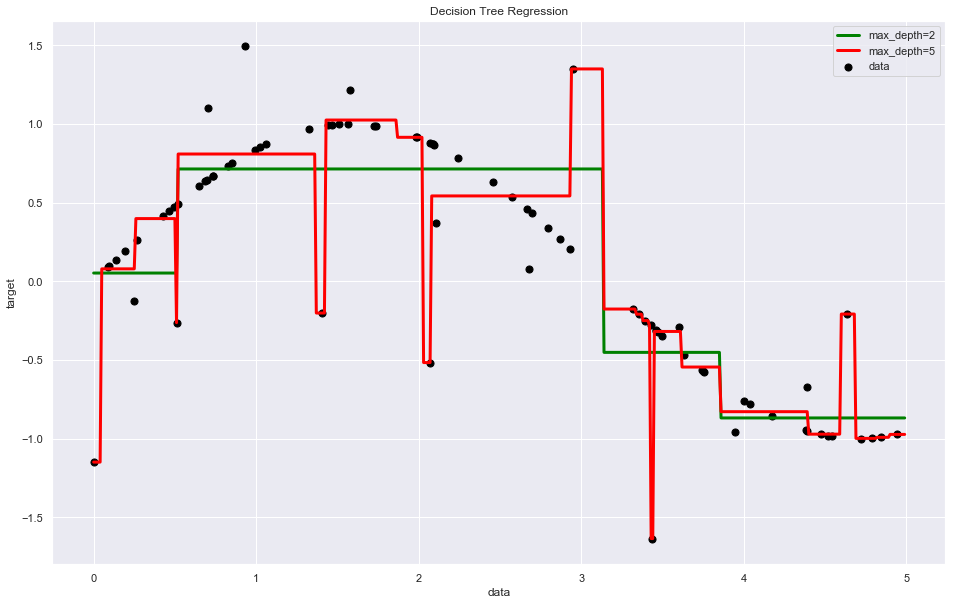

In [3]:
plt.figure(figsize=(16, 10))

plt.scatter(X, y, s=50, color="black", label="data")
plt.plot(X_test, y_1, color="green", label="max_depth=2", linewidth=3)
plt.plot(X_test, y_2, color="red", label="max_depth=5", linewidth=3)

plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

# Критерий останова построения дерева

Для любой непротиворечивой обучающей выборки можно построить решающее дерево, которое имеет нулевую ошибку на данной выборке. Если мы рассмотрим объекты, как точки в пространстве признаков, то каждую эту точку можно ограничить n-мерным кубиком, который не будет содержать других точек. n-мерный кубик прекрасно можно задать деревом.

Однако в этом случае имеет место **переобучение**. 

В связи с этим встаёт вопрос: в каком случае вершину следует объявить листовой?

Рассмотрим модельную задачу регрессии. Объектами будут являться точки на плоскости (т.е. каждый объект описывается 2 признаками), целевой переменной — расстояние от объекта до точки (0, 0).

Сгенерируем данные

In [4]:
data_x = np.random.normal(size=(100, 2))
data_y = (data_x[:, 0] ** 2 + data_x[:, 1] ** 2) ** 0.5

Визуализируем их

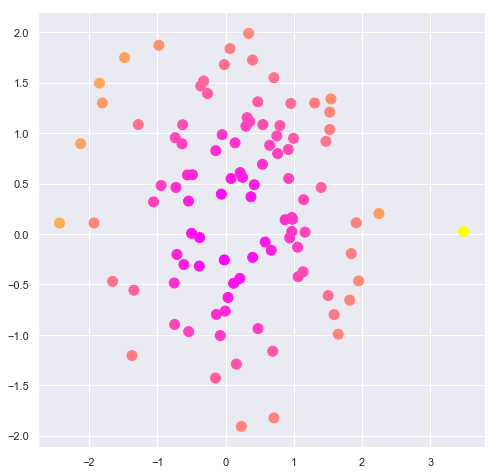

In [5]:
plt.figure(figsize=(8, 8))
plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=100, cmap='spring')
plt.show()

Обучим регрессор

In [6]:
clf = DecisionTreeRegressor()
clf.fit(data_x, data_y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

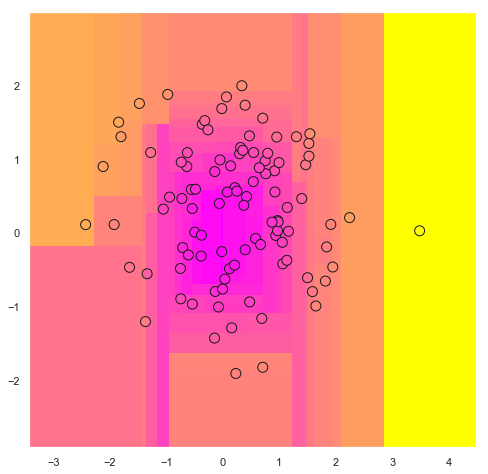

In [7]:
xx, yy = get_grid(data_x)

predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(8, 8))
plt.pcolormesh(xx, yy, predicted, cmap='spring')
plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=100, cmap='spring', edgecolor='k')

Посмотрим как будет выглядить разделение плоскости в зависимости от 
- минимального количества объектов в листе
- максимальной глубины дерева

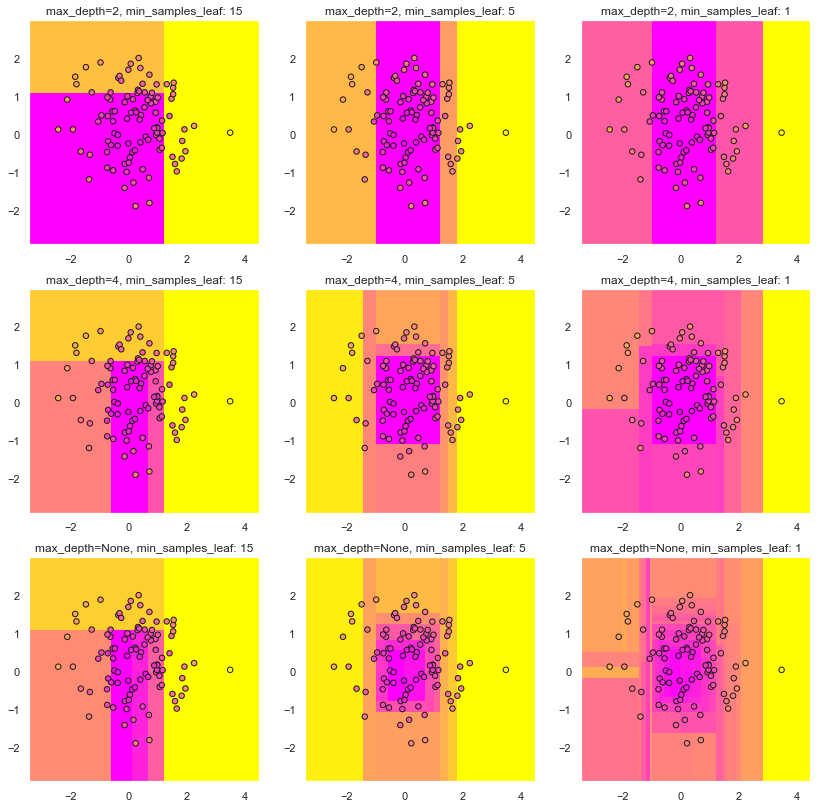

In [8]:
plt.figure(figsize=(14, 14))

for i, max_depth in enumerate([2, 4, None]):
    for j, min_samples_leaf in enumerate([15, 5, 1]):
        
        clf = DecisionTreeRegressor(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
        clf.fit(data_x, data_y)
        
        xx, yy = get_grid(data_x)
        predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
        
        plt.subplot2grid((3, 3), (i, j))
        plt.pcolormesh(xx, yy, predicted, cmap='spring')
        plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=30, cmap='spring', edgecolor='k')
        plt.title('max_depth=' + str(max_depth) + ', min_samples_leaf: ' + str(min_samples_leaf))

- Увеличение максимальной глубины и/или уменьшение минимального количества объектов выборки в листе приводит к увеличению качества на обучающей выборке и переобучению.

### Решающие деревья vs линейные модели

### Линейная зависимость

In [9]:
X_data, y_data = make_regression(n_samples=2000, noise=100, n_features=10)

Посмотрим на то, как меняется качество в зависимости от глубины дерева

In [10]:
np.mean(cross_val_score(
    DecisionTreeRegressor(max_depth=1), 
    X_data, y_data, 
    cv=5, scoring='neg_mean_squared_error',
))

-48473.04088652345

In [11]:
np.mean(cross_val_score(
    DecisionTreeRegressor(max_depth=5), 
    X_data, y_data, 
    cv=5, scoring='neg_mean_squared_error',
))

-36430.88102076461

In [12]:
np.mean(cross_val_score(
    DecisionTreeRegressor(max_depth=10), 
    X_data, y_data, 
    cv=5, scoring='neg_mean_squared_error',
))

-37959.82279618

100%|██████████| 20/20 [00:00<00:00, 16.75it/s]


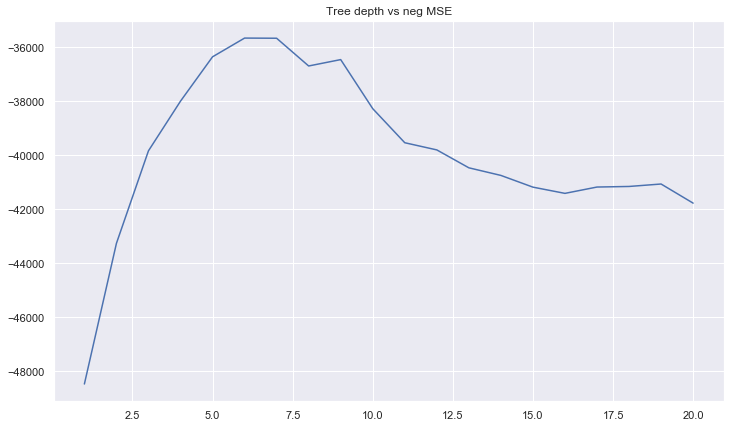

In [13]:
from tqdm import tqdm

depth_values = range(1, 21, 1)
cv_results = []

for depth_value in tqdm(depth_values):
    avg_score = np.mean(cross_val_score(
        DecisionTreeRegressor(max_depth=depth_value), 
        X_data, y_data, 
        cv=5, scoring='neg_mean_squared_error',
    ))
    cv_results.append(avg_score)
    
plt.figure(figsize=(12,7))
plt.title("Tree depth vs neg MSE")
plt.plot(depth_values, cv_results)
plt.show()

Теперь проделаем тоже самое для минимального количества примеров в листе

In [14]:
np.mean(cross_val_score(
    DecisionTreeRegressor(min_samples_leaf=2), 
    X_data, y_data, 
    cv=5, scoring='neg_mean_squared_error',
))

-39389.89406090657

In [15]:
np.mean(cross_val_score(
    DecisionTreeRegressor(min_samples_leaf=10), 
    X_data, y_data, 
    cv=5, scoring='neg_mean_squared_error',
))

-33193.11597035684

In [16]:
np.mean(cross_val_score(
    DecisionTreeRegressor(min_samples_leaf=20), 
    X_data, y_data, 
    cv=5, scoring='neg_mean_squared_error',
))

-33754.941058296274

100%|██████████| 10/10 [00:00<00:00, 22.28it/s]


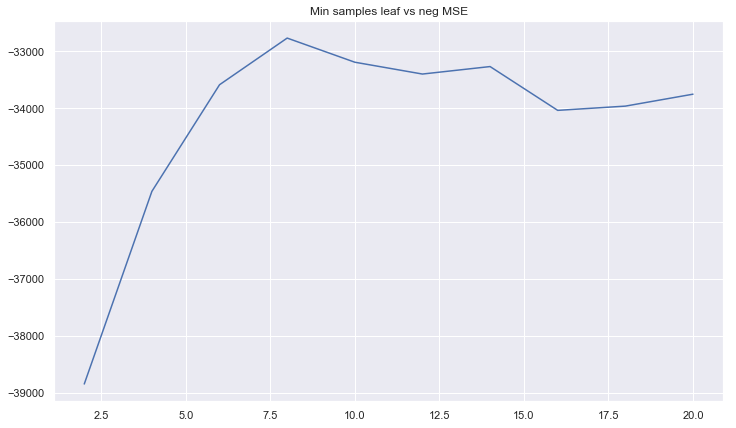

In [17]:
leaf_values = range(2, 21, 2)
cv_results = []

for leaf_value in tqdm(leaf_values):
    avg_score = np.mean(cross_val_score(
        DecisionTreeRegressor(min_samples_leaf=leaf_value), 
        X_data, y_data, 
        cv=5, scoring='neg_mean_squared_error',
    ))
    cv_results.append(avg_score)
    
plt.figure(figsize=(12,7))
plt.title("Min samples leaf vs neg MSE")
plt.plot(leaf_values, cv_results)
plt.show()

In [18]:
%%time
gs = GridSearchCV(
    DecisionTreeRegressor(random_state=42),
    param_grid ={
        'criterion': ['mse', 'mae'],
        'max_depth': range(1, 21, 3),
        'min_samples_leaf': range(1, 21, 3),
    },
    scoring='neg_mean_squared_error'
)
gs.fit(X_data, y_data)

print(gs.best_params_)
print(gs.best_score_)

{'criterion': 'mse', 'max_depth': 10, 'min_samples_leaf': 19}
-33717.89911357114
CPU times: user 16.6 s, sys: 88.4 ms, total: 16.7 s
Wall time: 16.8 s


Теперь сравним с обычной линейной регрессией

In [19]:
np.mean(cross_val_score(
    LinearRegression(), X_data, y_data, cv=5, scoring='neg_mean_squared_error'
))

-10175.718927418542

### Вывод

При соблюдении линейной зависимости между признаками и таргетом линейные модели проявляют себя лучше, нежели чем Decision Trees (внезапно)

### Нелинейная зависимость между признаками и таргетом

In [20]:
X_data, y_data = make_friedman1(n_samples=1000, noise=10, n_features=10)

Аналогично меняем глубину дерева

In [21]:
np.mean(cross_val_score(
    DecisionTreeRegressor(max_depth=1), 
    X_data, y_data, 
    cv=5, scoring='neg_mean_squared_error',
))

-120.14183380071918

In [22]:
np.mean(cross_val_score(
    DecisionTreeRegressor(max_depth=5), 
    X_data, y_data, 
    cv=5, scoring='neg_mean_squared_error',
))

-126.68619441370262

In [23]:
np.mean(cross_val_score(
    DecisionTreeRegressor(max_depth=10), 
    X_data, y_data, 
    cv=5, scoring='neg_mean_squared_error',
))

-192.99575046405076

100%|██████████| 20/20 [00:00<00:00, 32.75it/s]


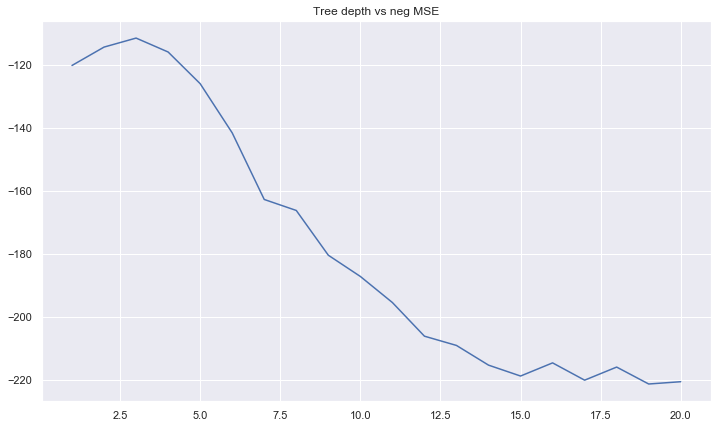

In [24]:
depth_values = range(1, 21, 1)
cv_results = []

for depth_value in tqdm(depth_values):
    avg_score = np.mean(cross_val_score(
        DecisionTreeRegressor(max_depth=depth_value), 
        X_data, y_data, 
        cv=5, scoring='neg_mean_squared_error',
    ))
    cv_results.append(avg_score)
    
plt.figure(figsize=(12,7))
plt.title("Tree depth vs neg MSE")
plt.plot(depth_values, cv_results)
plt.show()

Меняем минимальное количество примеров в листе

In [25]:
np.mean(cross_val_score(
    DecisionTreeRegressor(min_samples_leaf=2), 
    X_data, y_data, 
    cv=5, scoring='neg_mean_squared_error',
))

-215.19565814008502

In [26]:
np.mean(cross_val_score(
    DecisionTreeRegressor(min_samples_leaf=10), 
    X_data, y_data, 
    cv=5, scoring='neg_mean_squared_error',
))

-141.66122933536641

In [27]:
np.mean(cross_val_score(
    DecisionTreeRegressor(min_samples_leaf=20), 
    X_data, y_data, 
    cv=5, scoring='neg_mean_squared_error',
))

-123.4475010531904

100%|██████████| 19/19 [00:00<00:00, 55.64it/s]


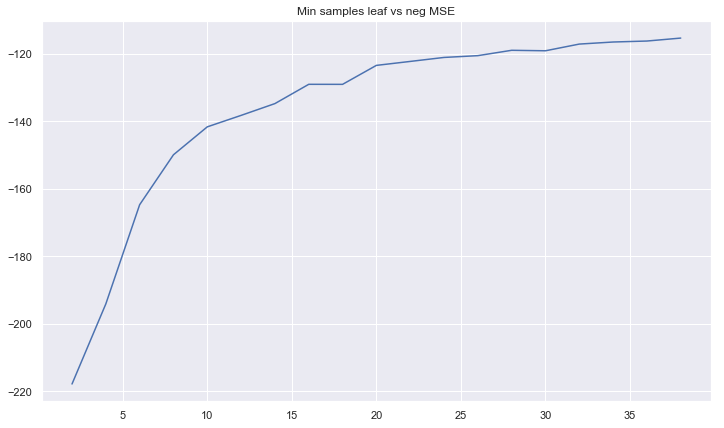

In [28]:
leaf_values = range(2, 40, 2)
cv_results = []

for leaf_value in tqdm(leaf_values):
    avg_score = np.mean(cross_val_score(
        DecisionTreeRegressor(min_samples_leaf=leaf_value), 
        X_data, y_data, 
        cv=5, scoring='neg_mean_squared_error',
    ))
    cv_results.append(avg_score)
    
plt.figure(figsize=(12,7))
plt.title("Min samples leaf vs neg MSE")
plt.plot(leaf_values, cv_results)
plt.show()

Подберем теперь оптимальные параметры

In [29]:
%%time
gs = GridSearchCV(
    DecisionTreeRegressor(random_state=42),
    param_grid ={
        'criterion': ['mse', 'mae'],
        'max_depth': range(1, 21, 3),
        'min_samples_leaf': range(1, 21, 3),
    },
    scoring='neg_mean_squared_error'
)
gs.fit(X_data, y_data)

print(gs.best_params_)
print(gs.best_score_)

{'criterion': 'mse', 'max_depth': 4, 'min_samples_leaf': 16}
-113.075862164238
CPU times: user 5.34 s, sys: 54.9 ms, total: 5.39 s
Wall time: 5.41 s


Сравним полученные результаты с линейной регрессией

In [30]:
np.mean(cross_val_score(
    LinearRegression(), X_data, y_data, cv=5, scoring='neg_mean_squared_error'
))

-105.39039508599176

### Вывод

При нелинейной зависимости между таргетом и признаками Linear Regression сравнима с Decision Trees

## Деревья vs линейные классификаторы

In [31]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from matplotlib.colors import ListedColormap

RANDOM_SEED = 42
CLUSTER_STD = 4

blobs = make_blobs(centers=2, cluster_std=CLUSTER_STD, random_state=RANDOM_SEED)
X_train, X_test, y_train, y_test = train_test_split(blobs[0], blobs[1], test_size=0.3, random_state=RANDOM_SEED)

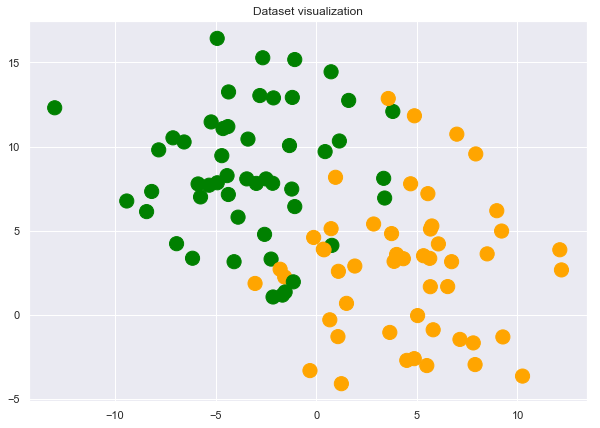

In [32]:
colors = ListedColormap(["green", "orange"])

plt.figure(figsize=(10,7))
plt.title("Dataset visualization")
plt.scatter(blobs[0][:,0], blobs[0][:,1], c=blobs[1], cmap=colors, s=200)
plt.show()

In [33]:
logreg_model = LogisticRegression()
logreg_model.fit(X_train, y_train)

tree_model = DecisionTreeClassifier(max_depth=10)
tree_model.fit(X_train, y_train)

logreg_preds = logreg_model.predict(X_test)
tree_preds = tree_model.predict(X_test)

logreg_score = accuracy_score(y_test, logreg_preds)
tree_score = accuracy_score(y_test, tree_preds)

print(f"Logreg acc - {logreg_score}, DT acc - {tree_score}")

weights = np.append(logreg_model.intercept_, logreg_model.coef_)
x1 = np.linspace(-4, 4, 100)
x2 = - weights[0] / weights[2] - weights[1] / weights[2] * x1

Logreg acc - 0.9333333333333333, DT acc - 0.8333333333333334


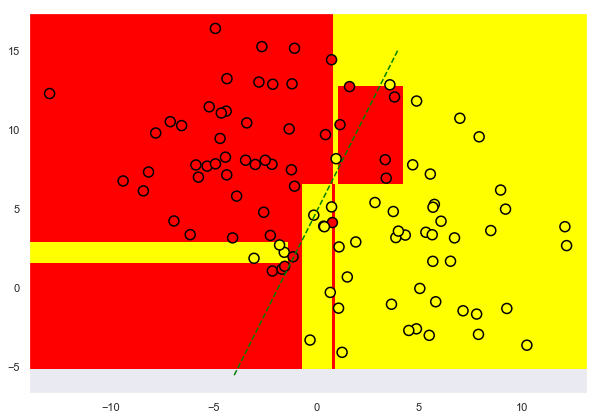

In [37]:
clf_tree = DecisionTreeClassifier(criterion='entropy', max_depth=50, 
                                  random_state=17)


# training the tree
clf_tree.fit(blobs[0], blobs[1])

# some code to depict separating surface
xx, yy = get_grid(blobs[0])
predicted = clf_tree.predict(np.c_[xx.ravel(), 
                                   yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(10,7))
plt.pcolormesh(xx, yy, predicted, cmap='autumn')
plt.plot(x1, x2, linestyle="--", color="green", label="hyperplane")
plt.scatter(blobs[0][:, 0], blobs[0][:, 1], c=blobs[1], s=100, 
            cmap='autumn', edgecolors='black', linewidth=1.5);
plt.show()

### Вывод

При линейно разделимой выборке деревья - фиаско

### Обобщим вышесказанное

**Преимущества**

- хорошо интерпретируются
- легко обобщаются для регрессии и классификации
- допускаются разнотипные данные

**Недостатки**

- Сравнение с линейными алгоритмами на линейно разделимой выборке - фиаско
- Переобучение
- Неустойчивость к шуму, составу выборки, критерию

**Способы устранения недостатков**

- прунинг (усечение) - применяется в основном в банковском скоринге (требование со стороны ЦБ к интерпретируемости модели)
- композиции (леса) деревьев

**Pruning**

<img src='img/pruning.png' Width=800>

### Неустойчивость решающих деревьев

Решающие деревья — это алгоритмы, неустойчивые к изменениям обучающей выборки, т.е. при малейших её изменениях итоговый классификатор может радикально измениться. Посмотрим, как будет меняться структура дерева при обучении на разных 90%-х подвыборках.

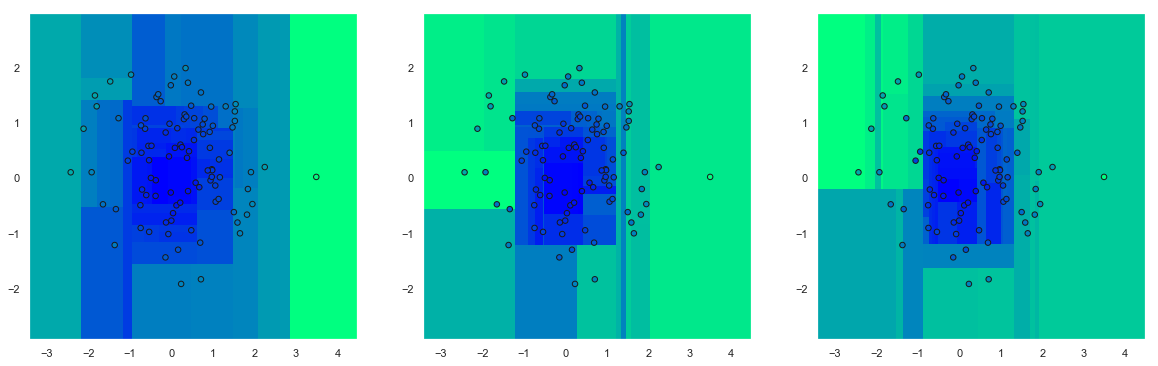

In [35]:
plt.figure(figsize=(20, 6))

for i in range(3):
    clf = DecisionTreeRegressor(random_state=42)

    indecies = np.random.randint(data_x.shape[0], size=int(data_x.shape[0] * 0.9))
    clf.fit(data_x[indecies], data_y[indecies])
    
    xx, yy = get_grid(data_x)
    predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    plt.subplot2grid((1, 3), (0, i))
    plt.pcolormesh(xx, yy, predicted, cmap='winter')
    plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=30, cmap='winter', edgecolor='k')